# WiDS Performance Evaluation Report
## TEAM 31, DLSM

## 1. Dany Raihan
## 2. Ho Lok To
## 3. Shawn Gabriel Intong
## 4. Mary Vo

#### This report presents a data-driven analysis aimed at providing property owners in Vancouver with insights into the potential revenue impacts of various property utilization strategies in light of the new Airbnb restrictions. The dataset used in this analysis includes historical Airbnb data, featuring key metrics such as property characteristics (e.g., size, location, amenities), guest feedback (ratings, reviews), and occupancy trends. The goal is to leverage this data to predict how different utilization strategies—namely long-term rentals, boutique hotels, and co-living spaces—may influence revenue outcomes in the context of the regulatory changes impacting short-term rentals.

#### By analyzing the dataset and employing predictive modeling techniques, the report aims to offer actionable insights for property owners in navigating the new regulatory landscape and making informed decisions on how to best optimize their properties for maximum revenue.

In [ ]:
# Install the Kaggle API client.
!pip install kaggle

# Upload Kaggle API credentials.
from google.colab import files
files.upload()

# Make sure the Kaggle API is configured correctly.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the competition data.
!kaggle competitions download -c effects-of-policy-on-the-housing-market


Saving kaggle.json to kaggle.json
  0% 0.00/1.21M [00:00<?, ?B/s]
100% 1.21M/1.21M [00:00<00:00, 128MB/s]


In [ ]:
! mkdir wids
! unzip effects-of-policy-on-the-housing-market.zip -d wids

Archive:  effects-of-policy-on-the-housing-market.zip
  inflating: wids/sample_submissions.csv  
  inflating: wids/test.csv           
  inflating: wids/train.csv          


## Preparing our Training / Testing dataset

###Here, we load the train and test csv files and split the train set into training and testing dataframes.

In [ ]:
# Store train and test csv in train and test

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
train = pd.read_csv('wids/train.csv')
X = train.drop(columns=['monthly_revenue'])
y = train['monthly_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
test = pd.read_csv('wids/test.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5352 non-null   int64  
 1   name                            5352 non-null   object 
 2   neighborhood_overview           3476 non-null   object 
 3   host_id                         5352 non-null   int64  
 4   host_name                       5352 non-null   object 
 5   host_response_time              4263 non-null   object 
 6   host_response_rate              4263 non-null   object 
 7   host_acceptance_rate            4620 non-null   object 
 8   host_is_superhost               5315 non-null   object 
 9   host_listings_count             5352 non-null   int64  
 10  host_total_listings_count       5352 non-null   int64  
 11  neighbourhood                   3476 non-null   object 
 12  neighbourhood_cleansed          53

## Column Analysis

Here, we drop the unused columns and analyze for NaN values

In [ ]:
# Drop the two unnamed columns and return the number of null values in all other columns

train = train.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
null_counts = train.isnull().sum()
null_counts

,0
id,0
name,0
neighborhood_overview,1876
host_id,0
host_name,0
host_response_time,1089
host_response_rate,1089
host_acceptance_rate,732
host_is_superhost,37
host_listings_count,0


From the result, there will be multiple columns that require imputing.

Since host response rate and host acceptance rate are both strings instead of integers, we need to convert it for numerical analyzing. The conversion will be done on a copy for analyzation.

In [ ]:
# Example DataFrame (you should use your 'train' DataFrame instead)
df = train.copy()

# Convert 'host_response_rate' and 'host_acceptance_rate' to numeric (remove '%' and handle missing data)
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str.replace('%', ''), errors='coerce').astype('Int64')
df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'].str.replace('%', ''), errors='coerce').astype('Int64')

# Convert 'price' column to numeric, remove dollar signs and commas, and convert to Int64
df['price'] = pd.to_numeric(df['price'].replace({'\$': '', ',': ''}, regex=True), errors='coerce').astype('Int64')

# Check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5352 non-null   int64  
 1   name                            5352 non-null   object 
 2   neighborhood_overview           3476 non-null   object 
 3   host_id                         5352 non-null   int64  
 4   host_name                       5352 non-null   object 
 5   host_response_time              4263 non-null   object 
 6   host_response_rate              4263 non-null   Int64  
 7   host_acceptance_rate            4620 non-null   Int64  
 8   host_is_superhost               5315 non-null   object 
 9   host_listings_count             5352 non-null   int64  
 10  host_total_listings_count       5352 non-null   int64  
 11  neighbourhood                   3476 non-null   object 
 12  neighbourhood_cleansed          53

## Numerical Feature Analysis

Here, we check the correlation of numerical columns with monthly revenue. From the table below, we can tell that accommodates, beds and reviews have the highest correlation with monthly revenue. To improve the quality of our model, only columns with correlation greater than 0.1 will be used.

In [ ]:
# Check the correlation between these values and monthly revenue, only include numeric columns

correlation_matrix = df.select_dtypes(include=['number']).corr()
correlation_with_revenue = correlation_matrix['monthly_revenue'].sort_values(ascending=False)
correlation_with_revenue

,monthly_revenue
monthly_revenue,1.000000
accommodates,0.453562
beds,0.418004
review_scores_value,0.149304
review_scores_rating,0.141020
review_scores_cleanliness,0.125695
review_scores_communication,0.123382
review_scores_checkin,0.113888
review_scores_accuracy,0.113768
review_scores_location,0.075474


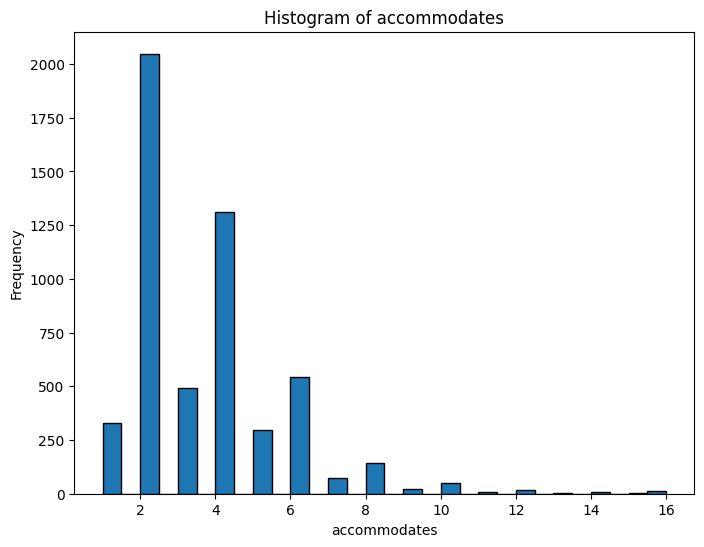

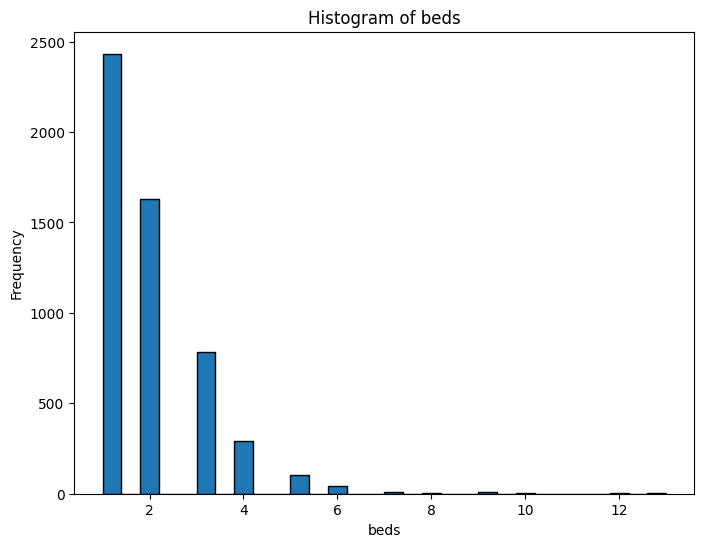

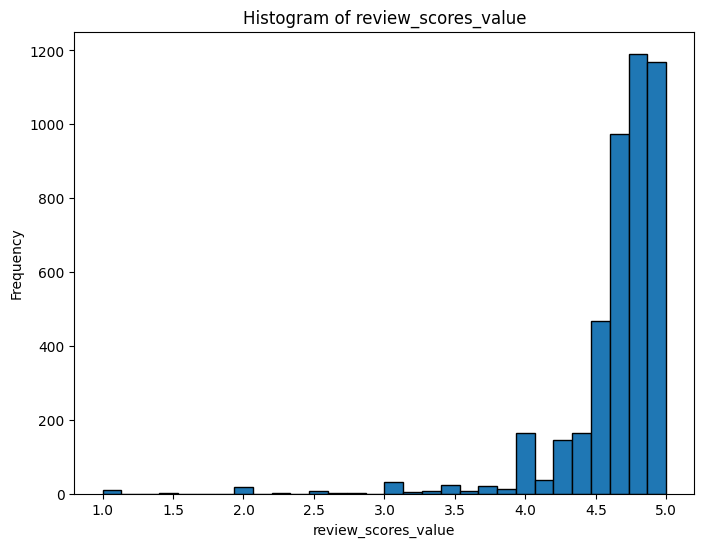

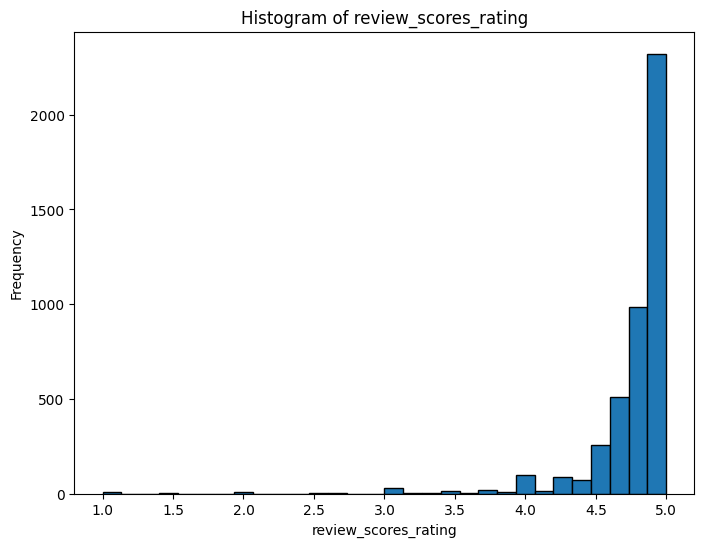

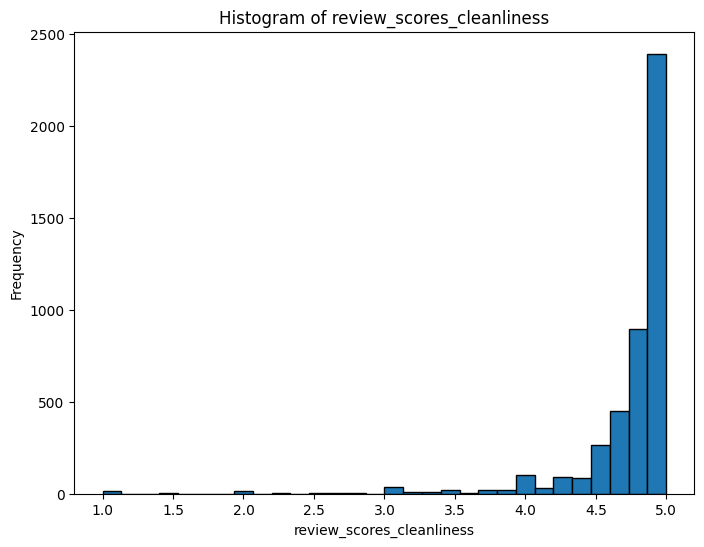

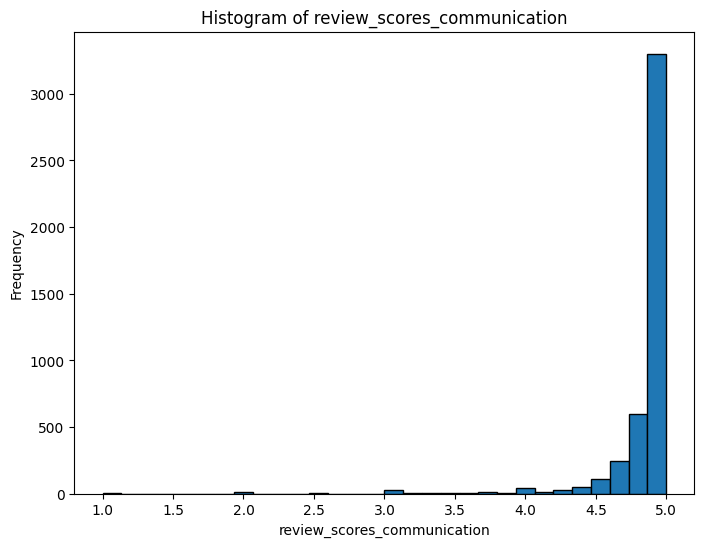

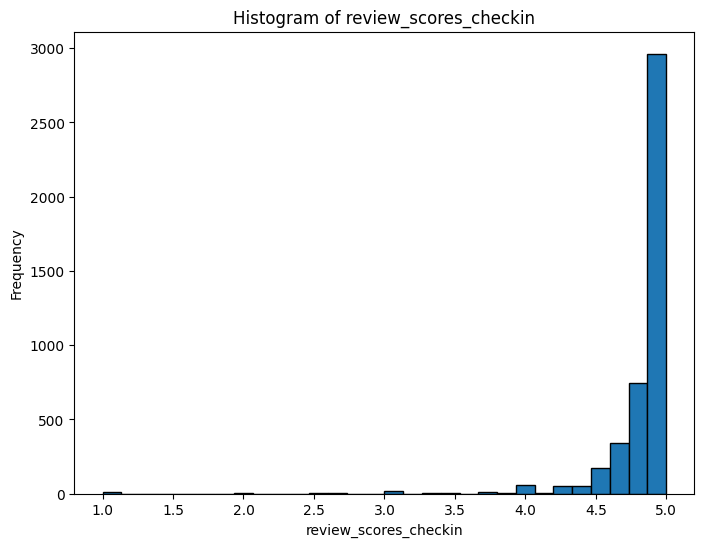

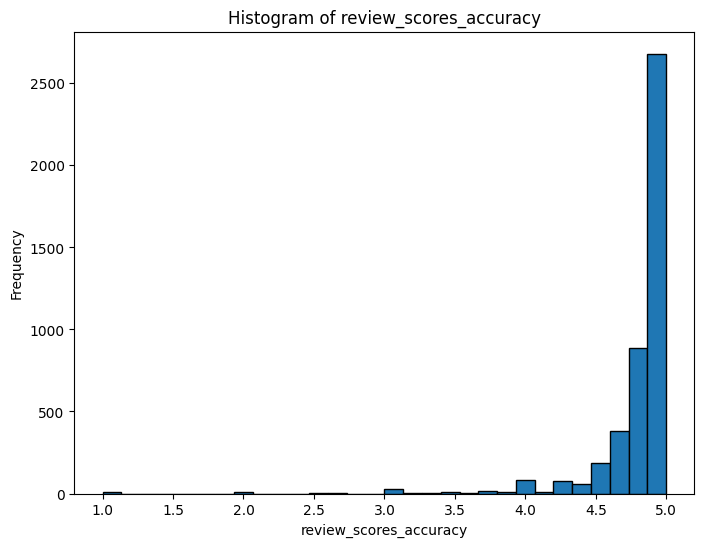

In [ ]:
# For all columns with correlation >0.1, create a histogram of that column

# Iterate through the columns with correlation > 0.1
for col in correlation_with_revenue[abs(correlation_with_revenue) > 0.1].index:
  if col != 'monthly_revenue':  # Exclude 'monthly_revenue' itself
    plt.figure(figsize=(8, 6))
    plt.hist(df[col].dropna(), bins=30, edgecolor='black')  # Handle potential NaN values
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

## Categorical Feature Analysis

To analyze the relationship between categorical features and our target, we create boxplot for all useful categorical features. From the correlation ratio results and graphs, property type and room type are the most important categorical features

In [ ]:
# Drop name, neighbourhood overview, host name in df

df = df.drop(columns=['name', 'neighborhood_overview', 'host_name'])


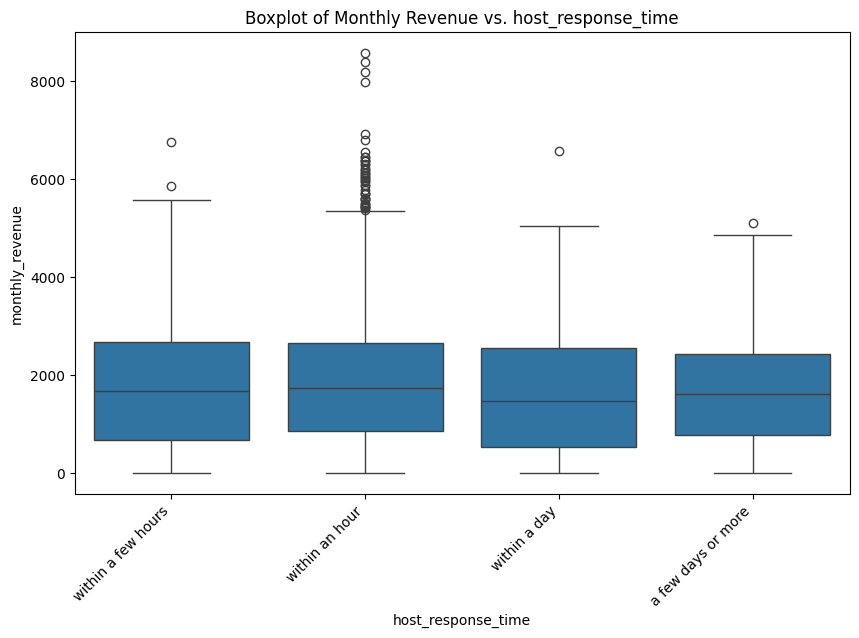

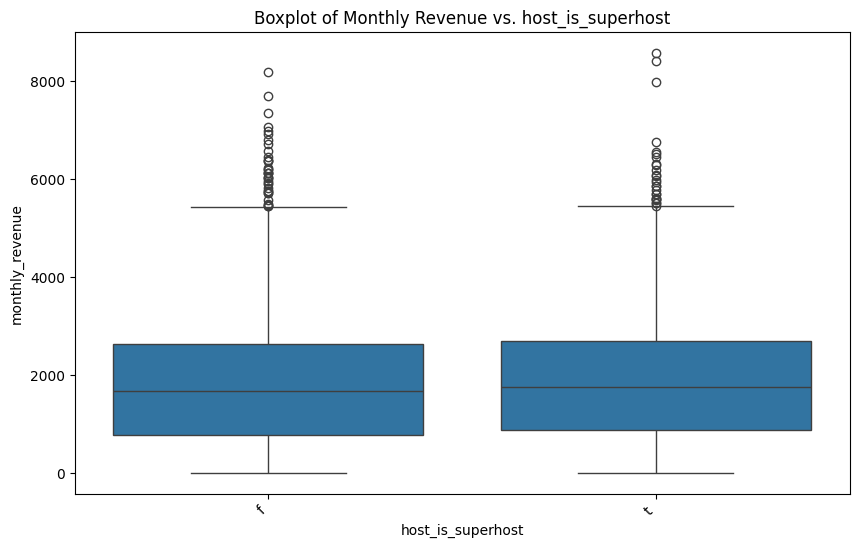

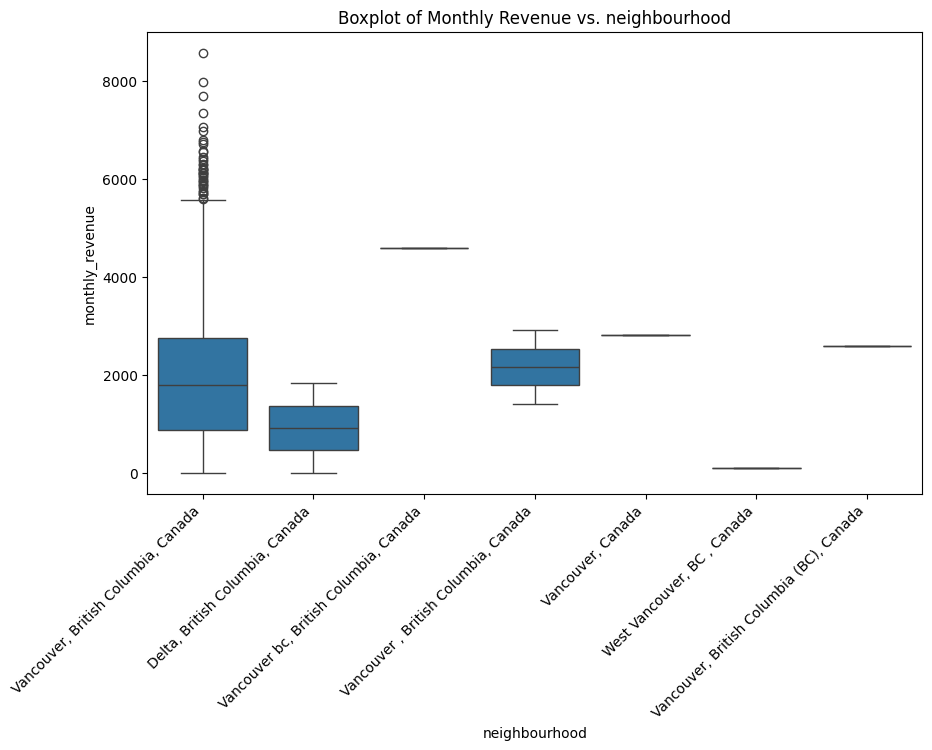

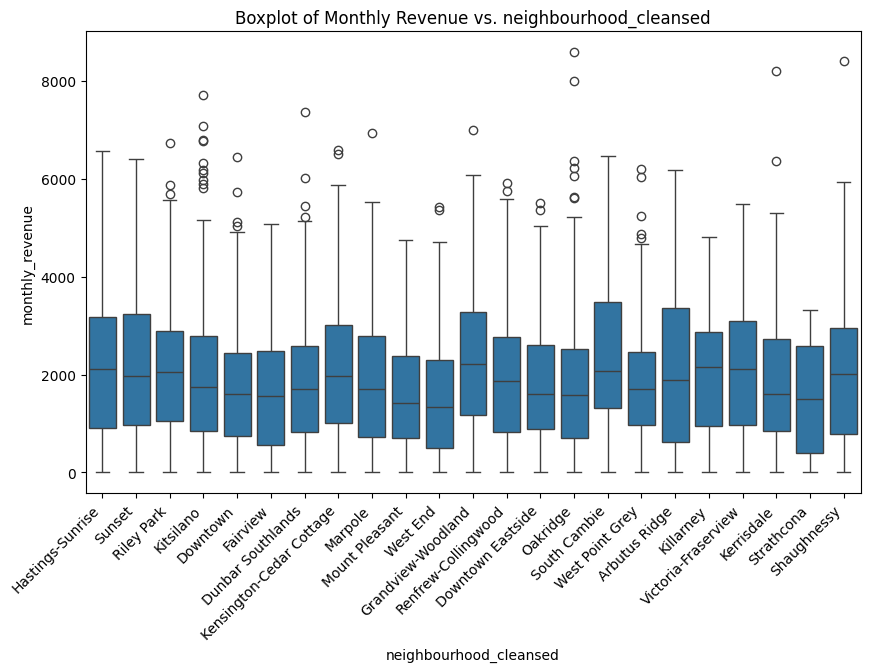

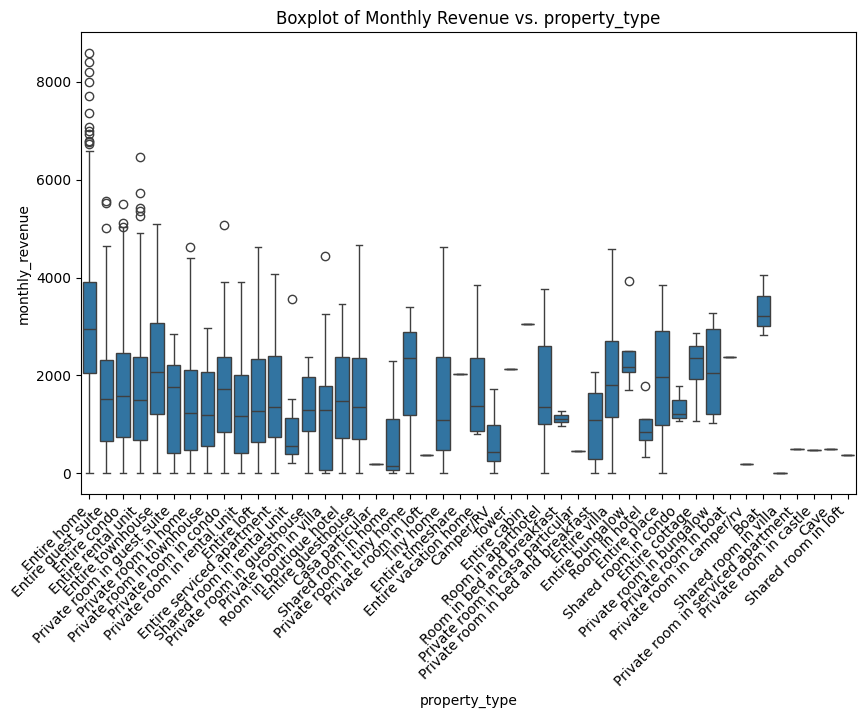

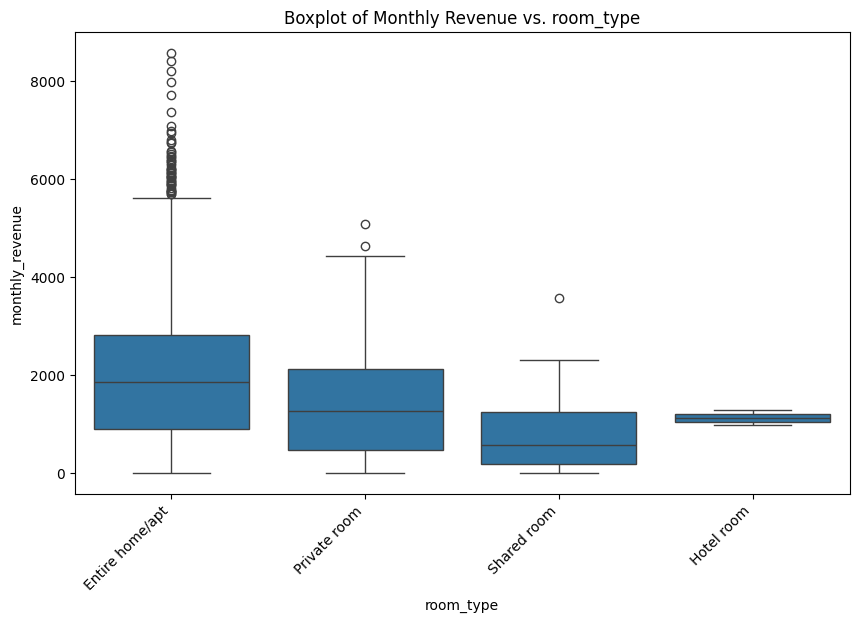

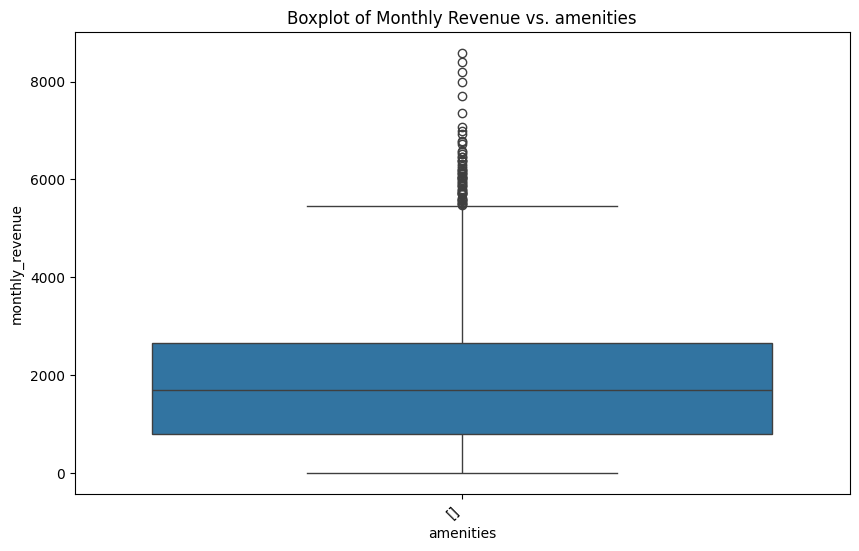

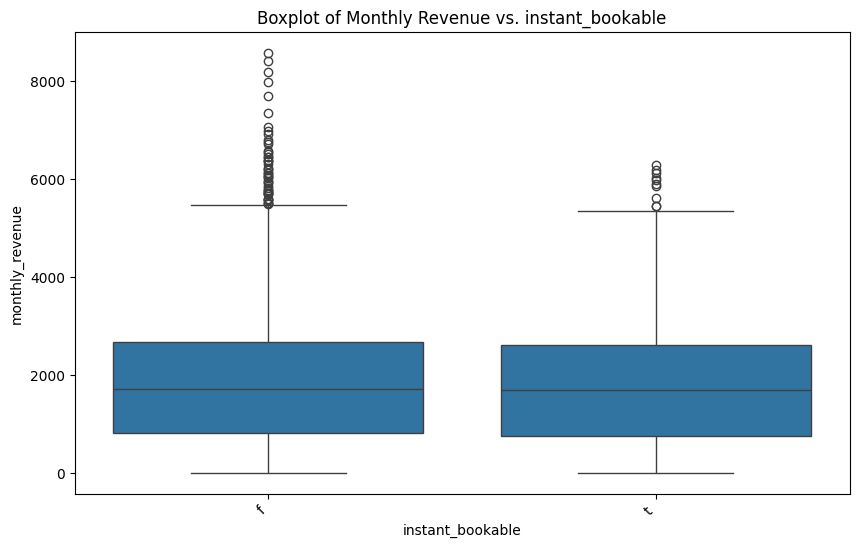

In [ ]:
# Create boxplots against monthly revenue for all object columns

# Identify object columns
object_cols = df.select_dtypes(include=['object']).columns

# Create boxplots for each object column against monthly revenue
for col in object_cols:
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=col, y='monthly_revenue', data=df)
  plt.title(f'Boxplot of Monthly Revenue vs. {col}')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.show()

In [ ]:
def correlation_ratio(categories, values):
    """
    Calculate the correlation ratio (eta-squared) between a categorical feature and a numerical target.

    Parameters:
        categories: Categorical variable (array-like)
        values: Numerical target variable (array-like)

    Returns:
        eta_squared: Correlation ratio value
    """
    # Convert to pandas Series for grouping
    categories = pd.Series(categories)
    values = pd.Series(values)

    # Calculate overall mean of the target variable
    overall_mean = values.mean()

    # Calculate group means and SSB
    group_means = values.groupby(categories).mean()
    ssb = sum(len(values[categories == cat]) * (mean - overall_mean) ** 2
              for cat, mean in group_means.items())

    # Calculate SST
    sst = sum((values - overall_mean) ** 2)

    return ssb / sst

object_columns = df.select_dtypes(include=['object']).columns

# Loop through each object column and calculate the correlation ratio with 'monthly_revenue'
for column in object_columns:
    eta_squared = correlation_ratio(df[column], df['monthly_revenue'])
    print(f"Correlation Ratio (Eta-Squared) for {column}: {eta_squared}")

Correlation Ratio (Eta-Squared) for host_response_time: 0.002187350792585808
Correlation Ratio (Eta-Squared) for host_is_superhost: 0.00037264392611071836
Correlation Ratio (Eta-Squared) for neighbourhood: 0.00324240188176198
Correlation Ratio (Eta-Squared) for neighbourhood_cleansed: 0.030570974014060608
Correlation Ratio (Eta-Squared) for property_type: 0.20200773007881254
Correlation Ratio (Eta-Squared) for room_type: 0.03241150919548727
Correlation Ratio (Eta-Squared) for amenities: 0.0
Correlation Ratio (Eta-Squared) for instant_bookable: 0.00045603497583095995


## Preprocessing

Now that the useful features are identified, we will begin our preprocessing step.

In [45]:
numeric_feats = ['beds', 'review_scores_rating', "accommodates",
                  'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value']
categorical_feats = ['property_type']

In [46]:
# Import all encoders and scalers from sklearn, import make pipeline, column transformer, import simple imputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

Since most numerical columns are skewed, we will use median to impute missing values and log transform it for better performance. As for categorical columns, we will impute missing values with the most frequent value.

In [48]:
from sklearn.preprocessing import FunctionTransformer
# Create a preprocessor for all of the feats, replace NaN in numeric with average, and replace NaN in ordinal with median, replace NaN in binary with false/0, use sklearn, preprocessor and column transformer
def log_transform(x):
    return np.log1p(x)

# Define a function to create a binary feature for missing values
def missing_indicator(x):
    return np.isnan(x).astype(int)

# Create pipelines for different feature types
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute with median
    ('log', FunctionTransformer(log_transform, validate=False)),  # Apply log transformation
    ('scaler', StandardScaler())  # Standardize
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Fill missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode
])

# Combine everything in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feats),
        ('cat', categorical_transformer, categorical_feats),
    ],
    remainder='drop'  # This ensures columns not specified are dropped
)

## Cross Validation With Our Model

XGBoost is used as it is a great model to study non-linear relationships and simple to tune

In [49]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,       # Maximum tree depth
    random_state=42    # For reproducibility
)

# Create a pipeline with preprocessing and the XGBoost model
xgb_pipeline = Pipeline(steps=[
    # ('cleaner', cleaner),  # Optional step for custom data cleaning
    ('preprocessor', preprocessor),  # Your preprocessing pipeline
    ('xgb', xgb_model)
])

# Perform cross-validation and get the scores
scores = cross_val_score(
    xgb_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',  # Negative MAE scoring
    error_score='raise'
)

# Convert negative MAE scores to positive values
scores = -scores

# Calculate the mean MAE across all folds
mean_mae = np.mean(scores)

# Calculate the percentage error (assuming actual value is non-zero)
percentage_error = (mean_mae / np.mean(abs(y_train))) * 100

# Print the results
print(f"Mean Cross-Validation MAE: {mean_mae}")
print(f"Percentage Error: {percentage_error}%")

Mean Cross-Validation MAE: 917.5458354163168
Percentage Error: 49.701793084835174%


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define the model
xgb_model = XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

xgb_pipeline = Pipeline(steps=[
    # ('cleaner', cleaner),  # Optional step for custom data cleaning
    ('preprocessor', preprocessor),  # Your preprocessing pipeline
    ('xgb', xgb_model)
])

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions={
        'xgb__' + k: v for k, v in param_dist.items()  # Prefix 'xgb__' to parameters
    },
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search on the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best MAE Score:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'xgb__n_estimators': 500, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01}
Best MAE Score: 916.0118229937216


## Model Evaluation on train testing set

Using the best parameters, we create our final model and test it on our training test set.

In [50]:
xgb_model = XGBRegressor(
    n_estimators=500,  # Number of trees
    learning_rate=0.01,  # Step size shrinkage
    max_depth=3,       # Maximum tree depth
    random_state=42    # For reproducibility
)
# Create a pipeline with preprocessing and the XGBoost model
xgb_pipeline = Pipeline(steps=[
    # ('cleaner', cleaner),  # Optional step for custom data cleaning
    ('preprocessor', preprocessor),  # Your preprocessing pipeline
    ('xgb', xgb_model)
])

In [51]:
from sklearn.metrics import mean_squared_error
# Fit the pipeline to the training data
xgb_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_pipeline.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on test set:", rmse)

RMSE on test set: 1087.0610372250915


## Final Model and Result

Finally, we create our final model and train it on the entire training set, and generate our predictions on the test set.

In [52]:
# Assuming xgb_pipeline is already fitted as shown in your provided code
xgb_model = XGBRegressor(
    n_estimators=500,  # Number of trees
    learning_rate=0.01,  # Step size shrinkage
    max_depth=3,       # Maximum tree depth
    random_state=42    # For reproducibility
)
# Create a pipeline with preprocessing and the XGBoost model
xgb_pipeline = Pipeline(steps=[
    # ('cleaner', cleaner),  # Optional step for custom data cleaning
    ('preprocessor', preprocessor),  # Your preprocessing pipeline
    ('xgb', xgb_model)
])
xgb_pipeline.fit(X, y)
# Make predictions on the test DataFrame
test_pred = xgb_pipeline.predict(test)

# Create a new DataFrame with 'id' and 'monthly_revenue'
submission_df = pd.DataFrame({'id': test['id'], 'monthly_revenue': test_pred})

# Display the DataFrame
submission_df

,id,monthly_revenue
0,4465400,3701.044678
1,608629349064811166,1070.350586
2,981894508939312892,1798.295166
3,52014961,1743.433838
4,836285112356489303,1554.446167
...,...,...
1334,32420319,1418.135864
1335,1038413325241000258,3782.373047
1336,966221396225646994,1527.039429
1337,18769488,1400.822632


In [53]:
# Assuming submission_df is already created as shown in your provided code

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Download the CSV file to your local machine
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>